In [1]:
import warnings

import os
import stat
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import Hyperband, HyperParameters
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

warnings.filterwarnings('ignore')

In [2]:
train_directory = '../b. Datasets/Garbage Dataset/Train'
test_directory = '../b. Datasets/Garbage Dataset/Test'

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   rotation_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   height_shift_range=0.2, 
                                   width_shift_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [4]:
train_data = train_datagen.flow_from_directory(directory=train_directory, 
                                               class_mode='categorical', 
                                               color_mode='rgb', 
                                               target_size=(80, 80), 
                                               batch_size=64, 
                                               shuffle=False,
                                               seed=0)
test_data = test_datagen.flow_from_directory(directory=test_directory, 
                                             class_mode='categorical', 
                                             color_mode='rgb', 
                                             target_size=(80, 80), 
                                             batch_size=64,
                                             shuffle=False,
                                             seed=0)

Found 960 images belonging to 8 classes.
Found 240 images belonging to 8 classes.


In [5]:
# Model building.
model = Sequential()

# Input layer
model.add(Input(shape=(80, 80, 3)))

# Convolutional layers
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=(2, 2)))

## 1x1 Convolutional layer to reduce computational cost
model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=(2, 2)))

## 1x1 Convolutional layer to reduce feature map size
model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same'))

# Flatten convert to 1D.
model.add(GlobalAveragePooling2D())

# Dense layers
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.3))

# Output layer.
model.add(Dense(units=8, activation='softmax'))

# Compile model
model.compile(
    optimizer=AdamW(learning_rate=0.005, weight_decay=1e-5,),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 80, 80, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_1 (ELU)                          │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 32)          │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_2 (ELU)                          │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,976 (124.91 KB)

 Trainable params: 31,976 (124.91 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               mode='max',
                               verbose=1,
                               patience=8)
model_checkpoint = ModelCheckpoint(filepath='best_cnn_model.keras', 
                                   save_best_only=True,
                                   monitor='val_accuracy', 
                                   mode='max',
                                   verbose=1)

In [8]:
total_epochs = 5
history = model.fit(train_data, 
                    epochs=total_epochs, 
                    validation_data=test_data, 
                    batch_size=64)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.0548 - loss: 2.4495 - val_accuracy: 0.1417 - val_loss: 2.1384
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.0708 - loss: 2.3005 - val_accuracy: 0.1250 - val_loss: 2.1413
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.1186 - loss: 2.1686 - val_accuracy: 0.1292 - val_loss: 2.1159
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.0998 - loss: 2.2302 - val_accuracy: 0.1583 - val_loss: 2.0366
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.1086 - loss: 2.2335 - val_accuracy: 0.1625 - val_loss: 2.0302


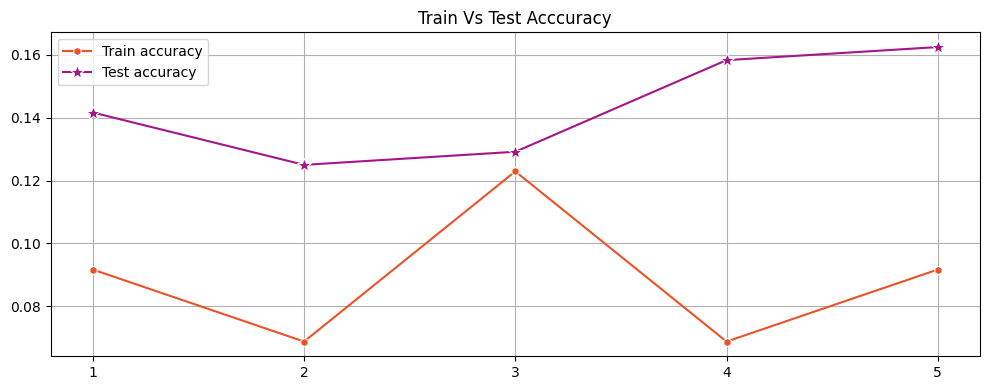

In [9]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['accuracy'], 
             label='Train accuracy', 
             color='#EC5228', 
             marker='h')
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['val_accuracy'], 
             label='Test accuracy', 
             color='#A5158C', 
             marker='*', 
             markersize=10)
plt.xticks(range(1, total_epochs + 1))
plt.title("Train Vs Test Acccuracy")
plt.grid()
plt.tight_layout()
plt.show()

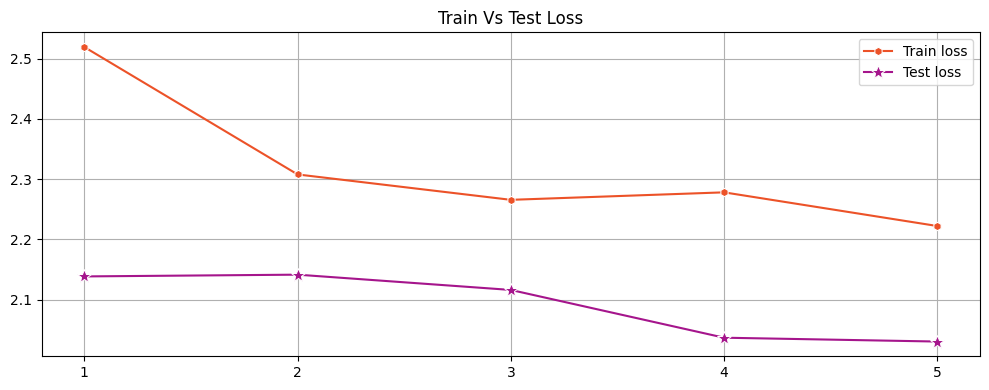

In [10]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['loss'], 
             label='Train loss', 
             color='#EC5228', 
             marker='h')
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['val_loss'], 
             label='Test loss', 
             color='#A5158C', 
             marker='*', 
             markersize=10)
plt.xticks(range(1, total_epochs + 1))
plt.title("Train Vs Test Loss")
plt.grid()
plt.tight_layout()
plt.show()

In [11]:
test_prediction = model.predict(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


In [12]:
test_prediction_class = np.argmax(test_prediction, axis=1)

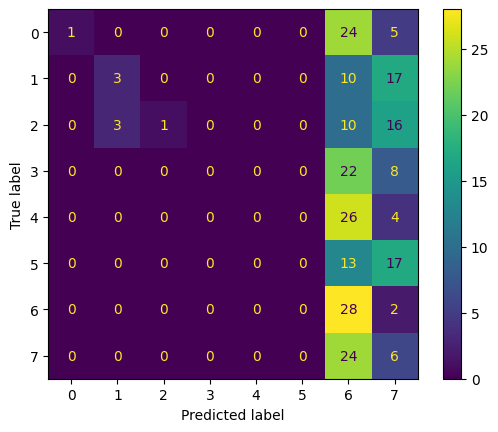

In [13]:
ConfusionMatrixDisplay(confusion_matrix(test_data.classes, test_prediction_class)).plot()

In [14]:
print(classification_report(test_data.classes, test_prediction_class))

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        30
           1       0.50      0.10      0.17        30
           2       1.00      0.03      0.06        30
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        30
           6       0.18      0.93      0.30        30
           7       0.08      0.20      0.11        30

    accuracy                           0.16       240
   macro avg       0.34      0.16      0.09       240
weighted avg       0.34      0.16      0.09       240



In [15]:
test_loss, test_accuracy = model.evaluate(test_data)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.1020 - loss: 2.0727
Test loss: 2.030231475830078
Test accuracy: 0.16249999403953552


In [16]:
submission_df = pd.DataFrame({
    'FileName': test_data.filenames,
    'Class': test_prediction_class
}).sort_values(by='FileName', ascending=True)

In [17]:
display(submission_df.head(2))
display(submission_df.tail(2))

,FileName,Class
0,battery\battery121.jpg,6
1,battery\battery122.jpg,0


,FileName,Class
238,shoes\shoes149.jpg,6
239,shoes\shoes150.jpg,7


In [18]:
submission_df.to_csv("../c. Output Files/Image Classification - Garbage Data - CNN.csv", index=False)